### Experiment with Feature Selection

This is a Make-up experiment based on the previous version

1. Comparison Experiments - (presented in torn_pred_30m.ipynb)

When calculating shsr features, we use the shsr frame 30min before weather phenomena (tornado/wind/hail) happened. Data saved as balanced_comb_bf30min.csv file.

Short Conclusion - Extracting features from SHSR frame 30min before weather phenomenon happens will - 1)result in worse overall performance, 2) do harm to different categories' performances, not only tornado (however, under certain situation, tornado's prediction performance is not negatively influenced). 

2. Feature and Hyper-parameter Selection -
Use Boruta, RFE, RFA to run experiment, such that we can obtain better performances because of better feature combinations and best threshold.


In [1]:
# Load necessary libraries. 
import os 
import tqdm
import random 
import numpy as np 
import pandas as pd 
import sklearn.metrics as metrics
import shap 

# import our models 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
threshold = 45          # can change threshold at certain window ... 
nc_path = "data/SHSRdata/"
csv_path = "data/"
cls_names = { "torn":0, "wind":1, "hail":2 }

vars = [ 'temp', 'humidity', 'dew', 'precip', 'preciptype', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility']
stat_vars = [ "mean", "max", "min", "var", "nonzeros", "above_threshold" ]
vars += stat_vars

def read_data( csv, vars, set='train' ):
    dframe = pd.read_csv( csv )
    x = dframe[ dframe['set']==set ][vars]
    y = dframe[ dframe['set']==set ]['label'].values        
    return x,y 

In [3]:
# Choose the Data we will use for training and test.
csv_file = "balanced_comb.csv"
train_x, train_y = read_data( csv_path + "/" + csv_file, vars, set="train" )
print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )
print( type(train_x), type(train_y) ) 
val_x, val_y = read_data( csv_path + "/" + csv_file, vars, set="val" )
print( f"The number of data points in val set:\n", val_x.shape, val_y.shape )
test_x, test_y = read_data( csv_path + "/" + csv_file, vars, set="test" )
print( f"The number of data points in test set:\n", test_x.shape, test_y.shape )

# train_x, train_y, val_x, val_y, test_x, test_y = read_data( csv_path + "/" + csv_file, vars, random_balanced = True )  
# print( f"The number of data points in train set:\n", train_x.shape, train_y.shape )

The number of data points in train set:
 (2747, 16) (2747,)
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>
The number of data points in val set:
 (691, 16) (691,)
The number of data points in test set:
 (654, 16) (654,)


## 2. Machine Learning Models with Feature Selection 

Models
1. Random Forest;
2. LightGBM;
3. XGBoost;

Evaluation:
1. Accuracy, Precision, Recall, F1 Score; 
2. Confusion Matrix;

Feature Selection Methods 
1. Boruta
2. RFE
3. RFA 

In [4]:
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 

def evaluate( model, train_x, train_y, test_x, test_y ):
    """ uses the model to calculate a set of scores """
    # print('Test Accuracy     :',model.score(test_x, test_y))
    # print('Training Accuracy    :',model.score(train_x,train_y))
    pred_y = model.predict(test_x)
    accuracy = accuracy_score( test_y, pred_y )
    precision = precision_score( test_y, pred_y, average='weighted', zero_division=True )
    recall = recall_score( test_y, pred_y, average='weighted' )
    f1 = f1_score( test_y, pred_y, average='weighted')
    print('Testing accuracy :', accuracy )
    print('Testing precision :', precision )
    print('Testing recall    :', recall )
    print('F1 score          :', f1 )
    # ROC AUC
    probs=model.predict_proba(test_x) 
    print('ROC AUC           : %f' % roc_auc_score(test_y, probs, average="weighted", multi_class='ovo'))
    conf_mat = confusion_matrix( test_y, pred_y, normalize='true' )
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=["torn", "wind", "hail"])
    disp = disp.plot(cmap=plt.cm.Blues)   # ,values_format='g'
    plt.show()

### Load Necessary Dependencies 


In [5]:
from operator import itemgetter
from boruta import BorutaPy
from sklearn.feature_selection import RFE
from feature_engine.selection import RecursiveFeatureAddition   # the only RFA I've found ... 

#### 1. Logistic Regression 

Logistic Regression is ...

====================== Original Logistic Regression =======================
Testing accuracy : 0.6223241590214067
Testing precision : 0.6198559407355368
Testing recall    : 0.6223241590214067
F1 score          : 0.6206444492679603
ROC AUC           : 0.793429


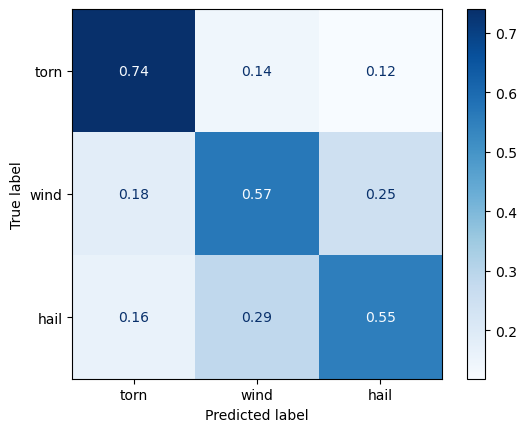

====================== Logistic Regression with RFE =======================
Testing accuracy : 0.5948012232415902
Testing precision : 0.5916354963413775
Testing recall    : 0.5948012232415902
F1 score          : 0.592096407412311
ROC AUC           : 0.759693


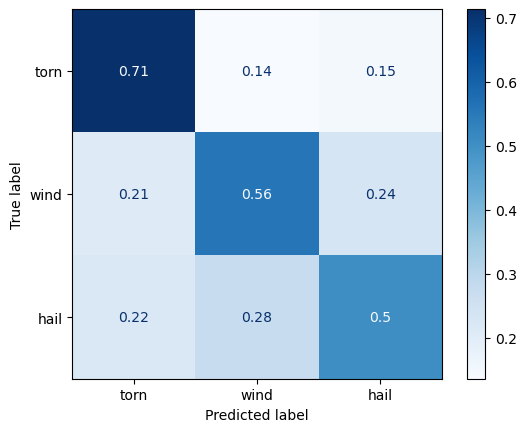

1 temp
1 humidity
1 dew
1 precip
1 preciptype
1 windspeed
1 pressure
1 cloudcover
1 visibility
1 mean
1 max
1 min
2 above_threshold
3 winddir
4 var
5 nonzeros
============================= Logistic Regression with RFA =============================
['temp', 'dew', 'preciptype', 'windspeed', 'mean', 'max', 'nonzeros']
0.5860910269565148
{'preciptype': 0, 'temp': 0.047322245289172116, 'mean': 0.013835795133669004, 'dew': 0.03567462874141947, 'humidity': 0.00400489973830942, 'visibility': -0.0025485002505547527, 'windspeed': 0.029489902243857502, 'min': 0.008008606358523851, 'max': 0.030942722377327536, 'precip': 0.0003631056068595928, 'pressure': 0.0003615147827331633, 'cloudcover': 0.00036509413701768523, 'winddir': -0.001097668647242811, 'var': -0.0014615696661656186, 'nonzeros': 0.01819863030042712, 'above_threshold': 0.00036429872495447047}
Testing accuracy : 0.6223241590214067
Testing precision : 0.6225173604155816
Testing recall    : 0.6223241590214067
F1 score          : 0.62187412

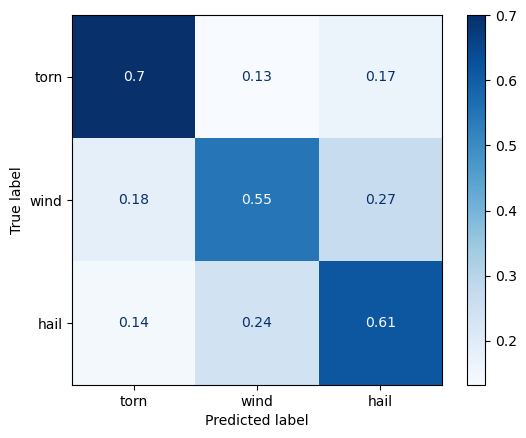

In [6]:
print('====================== Original Logistic Regression =======================')
lg = LogisticRegression(C=0.01,penalty='l2',max_iter=30000, 
                           solver="lbfgs",multi_class='multinomial', 
                           random_state=0)

lg.fit(train_x.values,train_y) 
evaluate(lg, train_x.values, train_y, test_x.values, test_y) 

print('====================== Logistic Regression with RFE =======================')
lg = LogisticRegression(C=0.01,penalty='l2', max_iter=30000, solver="lbfgs",
                           multi_class='multinomial', random_state=0)

rfe_lg = RFE(lg, n_features_to_select=12)
rfe_lg.fit( train_x, train_y )
evaluate(rfe_lg, train_x, train_y, test_x, test_y) 
features = train_x.columns.to_list()
for x, y in (sorted(zip(rfe_lg.ranking_ , features), key=itemgetter(0))):
    print(x, y)

print('============================= Logistic Regression with RFA =============================')
lg = LogisticRegression(C=0.01,penalty='l2', max_iter=30000, solver="lbfgs",
                           multi_class='multinomial', random_state=0)
rfa_lg = RecursiveFeatureAddition(estimator=lg, scoring="accuracy", cv=3)
vars = rfa_lg.fit_transform(train_x, train_y) 
vars = vars.columns.tolist() 
print(vars)
print( rfa_lg.initial_model_performance_ )
print( rfa_lg.performance_drifts_ ) 

lg = LogisticRegression(C=0.01,penalty='l2', max_iter=30000, solver="lbfgs",
                           multi_class='multinomial', random_state=0)
lg.fit( train_x[vars], train_y )
evaluate(lg, train_x[vars], train_y, test_x[vars], test_y) 

#### 2. Random Forest 

Random Forest is ...

======================= Original Random Forest =======================
Testing accuracy : 0.6651376146788991
Testing precision : 0.6676387270138627
Testing recall    : 0.6651376146788991
F1 score          : 0.6642616931145061
ROC AUC           : 0.833347


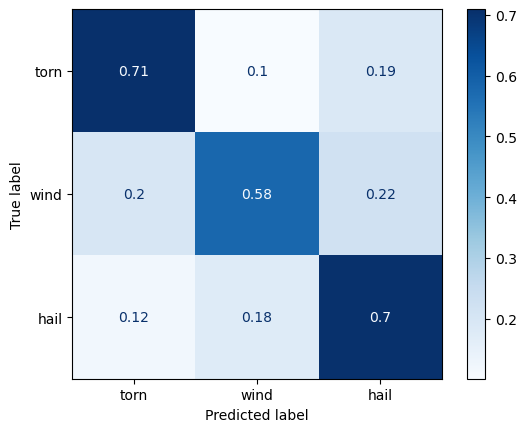

============================= Random Forest with RFE =============================
Testing accuracy : 0.672782874617737
Testing precision : 0.6752459010425768
Testing recall    : 0.672782874617737
F1 score          : 0.6726120917801504
ROC AUC           : 0.833157


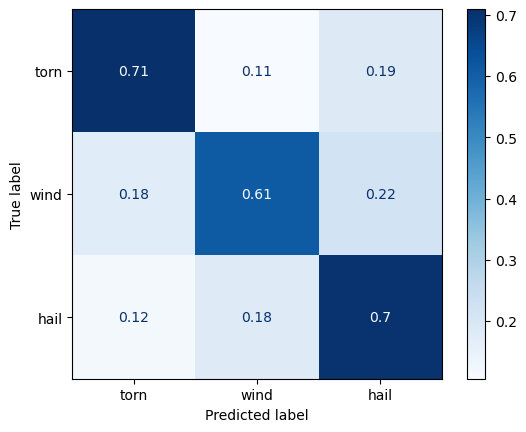

1 temp
1 humidity
1 dew
1 windspeed
1 winddir
1 pressure
1 cloudcover
1 mean
1 max
1 var
1 nonzeros
1 above_threshold
2 preciptype
3 precip
4 visibility
5 min
============================= Random Forest with RFA =============================
['temp', 'humidity', 'windspeed', 'max', 'nonzeros']
0.6436056824237797
{'max': 0, 'humidity': 0.11321895307864238, 'nonzeros': 0.018197437182332354, 'temp': 0.029490299949889054, 'above_threshold': -0.0025488979565863046, 'dew': 0.0029116058574143455, 'winddir': 0.007641921397379847, 'cloudcover': -0.001453217839501808, 'pressure': 0.008007810946460858, 'windspeed': 0.012737728780394808, 'var': -0.004730713245997165, 'mean': 0.001456399487754556, 'precip': -0.0065502183406115355, 'preciptype': -0.0032735183461793937, 'visibility': -0.004003706620214764, 'min': -0.0036406010133551714}
Testing accuracy : 0.6391437308868502
Testing precision : 0.6379543748891426
Testing recall    : 0.6391437308868502
F1 score          : 0.6380665001218099
ROC AUC    

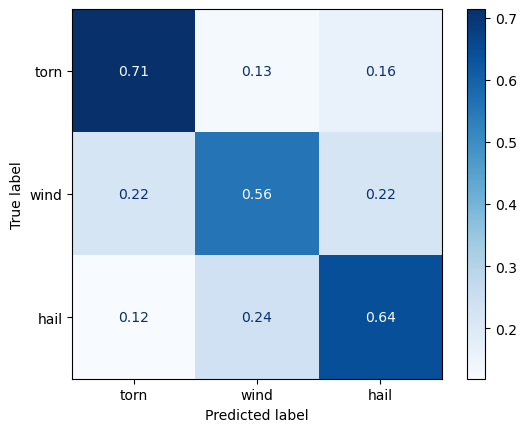

In [7]:
print('======================= Original Random Forest =======================')

rfc = RandomForestClassifier( n_estimators= 100, max_depth=15, min_samples_split=110,
                                 min_samples_leaf=25,max_features='sqrt' ,oob_score=True,random_state=10 )
rfc.fit(train_x.values, train_y)
evaluate(rfc, train_x.values, train_y, test_x.values, test_y)


print('============================= Random Forest with RFE =============================')

rfc = RandomForestClassifier( n_estimators= 100, max_depth=15, min_samples_split=110,
                            min_samples_leaf=25,max_features='sqrt' ,oob_score=True,random_state=10 )
rfe_rfc = RFE(rfc, n_features_to_select=12)
rfe_rfc.fit( train_x, train_y )
evaluate(rfe_rfc, train_x, train_y, test_x, test_y) 
features = train_x.columns.to_list()
for x, y in (sorted(zip(rfe_rfc.ranking_ , features), key=itemgetter(0))):
    print(x, y)


print('============================= Random Forest with RFA =============================')
rfc = RandomForestClassifier( n_estimators= 100, max_depth=15, min_samples_split=110,
                            min_samples_leaf=25,max_features='sqrt' ,oob_score=True,random_state=10 )
rfa_rfc = RecursiveFeatureAddition(estimator=rfc, scoring="accuracy", cv=3)
vars = rfa_rfc.fit_transform(train_x, train_y) 
vars = vars.columns.tolist() 
print(vars)
print( rfa_rfc.initial_model_performance_ ) 
print( rfa_rfc.performance_drifts_ ) 

rfc = RandomForestClassifier( n_estimators= 100, max_depth=15, min_samples_split=110,
                            min_samples_leaf=25,max_features='sqrt' ,oob_score=True,random_state=10 )
rfc.fit( train_x[vars], train_y )
evaluate(rfc, train_x[vars], train_y, test_x[vars], test_y) 

# print('============================= Random Forest with Boruta =============================')
# feat_selector = BorutaPy(
#     verbose=2,
#     estimator=rfc,
#     n_estimators=100 )

# feat_selector.fit(np.array(train_x, dtype=float), np.array(train_y, dtype=int))
# evaluate(feat_selector, train_x.values, train_y, test_x.values, test_y) 

#### 3. LightGBM
LightGBM is ...

============================= Original LightGBM =============================
Testing accuracy : 0.7217125382262997
Testing precision : 0.7271463676699748
Testing recall    : 0.7217125382262997
F1 score          : 0.7216667230566888
ROC AUC           : 0.864818


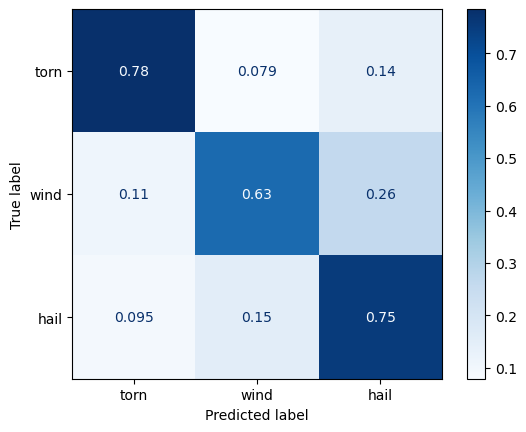

============================= LightGBM with RFE =============================
Testing accuracy : 0.7186544342507645
Testing precision : 0.7221367426618297
Testing recall    : 0.7186544342507645
F1 score          : 0.7179770507803472
ROC AUC           : 0.865118


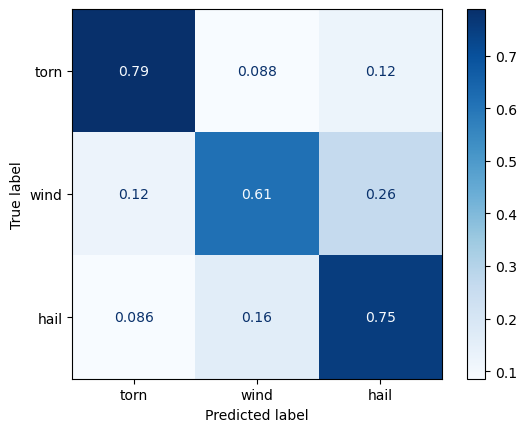

1 temp
1 humidity
1 dew
1 windspeed
1 winddir
1 pressure
1 cloudcover
1 visibility
1 mean
1 max
1 var
1 nonzeros
2 precip
3 min
4 preciptype
5 above_threshold
============================= LightGBM with RFA =============================
['humidity', 'dew', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'max', 'nonzeros']
0.6781901989325569
{'pressure': 0, 'cloudcover': 0.033495995100261744, 'humidity': 0.026212804543393642, 'windspeed': 0.030943517789390862, 'dew': 0.08080471838435899, 'winddir': 0.04223319890869459, 'nonzeros': 0.017837910929757173, 'temp': -0.0018206982127090265, 'max': 0.024753223407386282, 'mean': 0.0025425346600806975, 'var': 0.005458515283842669, 'visibility': 0.0014552063696597894, 'precip': 0.0007238249775295413, 'min': -0.0007325745102250147, 'preciptype': 0.0014528201334700341, 'above_threshold': 0.0}
Testing accuracy : 0.6957186544342507
Testing precision : 0.697241582469794
Testing recall    : 0.6957186544342507
F1 score          : 0.6955078159233583
ROC

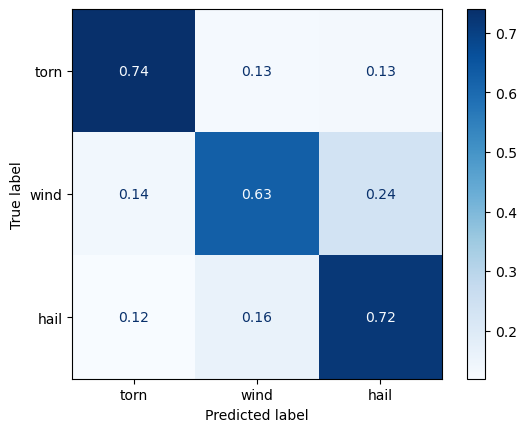

In [8]:
print('============================= Original LightGBM =============================')
lgb = LGBMClassifier( n_estimators=5000, verbose=-1 )
lgb.fit(train_x, train_y)
evaluate( lgb, train_x, train_y, test_x, test_y )

print('============================= LightGBM with RFE =============================')
lgb = LGBMClassifier( n_estimators=5000, verbose=-1 )
rfe_lgb = RFE(lgb, n_features_to_select=12)
rfe_lgb.fit( train_x, train_y )
evaluate(rfe_lgb, train_x, train_y, test_x, test_y) 
features = train_x.columns.to_list()
for x, y in (sorted(zip(rfe_lgb.ranking_ , features), key=itemgetter(0))):
    print(x, y)

print('============================= LightGBM with RFA =============================')
lgb = LGBMClassifier( n_estimators=5000, verbose=-1 )  
rfa_lgb = RecursiveFeatureAddition(estimator=lgb, scoring="accuracy", cv=3)
vars = rfa_lgb.fit_transform(train_x, train_y) 
vars = vars.columns.tolist() 
print(vars)
print( rfa_lgb.initial_model_performance_ ) 
print( rfa_lgb.performance_drifts_ ) 

lgb = LGBMClassifier( n_estimators=5000, verbose=-1 )  
lgb.fit( train_x[vars], train_y )
evaluate(lgb, train_x[vars], train_y, test_x[vars], test_y) 

### XGBoost Model 

In this section, we want to find our better(/best) XGBOOST model (with better feature combinations) by using:
1. Boruta
2. RFE
3. RFA


============================= Original XGBoost =============================
Testing accuracy : 0.7217125382262997
Testing precision : 0.7258069409620755
Testing recall    : 0.7217125382262997
F1 score          : 0.7213170646910472
ROC AUC           : 0.867028


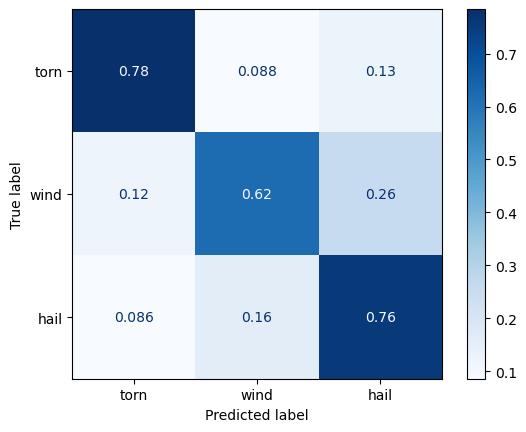

============================= XGBoost with RFE =============================
Testing accuracy : 0.7171253822629969
Testing precision : 0.7211169183389287
Testing recall    : 0.7171253822629969
F1 score          : 0.7171799135072724
ROC AUC           : 0.864098


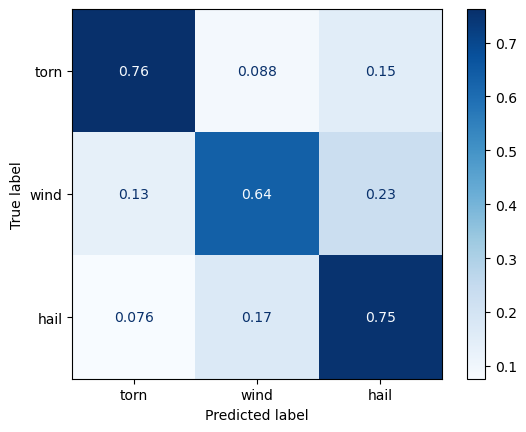

1 temp
1 humidity
1 dew
1 precip
1 windspeed
1 winddir
1 pressure
1 cloudcover
1 mean
1 max
1 var
1 nonzeros
2 min
3 visibility
4 above_threshold
5 preciptype
============================= XGBoost with RFA =============================
['temp', 'humidity', 'dew', 'winddir', 'pressure', 'max', 'var', 'nonzeros']
0.6781901989325569
{'pressure': 0, 'cloudcover': 0.033495995100261744, 'humidity': 0.026212804543393642, 'windspeed': 0.030943517789390862, 'dew': 0.08080471838435899, 'winddir': 0.04223319890869459, 'nonzeros': 0.017837910929757173, 'temp': -0.0018206982127090265, 'max': 0.024753223407386282, 'mean': 0.0025425346600806975, 'var': 0.005458515283842669, 'visibility': 0.0014552063696597894, 'precip': 0.0007238249775295413, 'min': -0.0007325745102250147, 'preciptype': 0.0014528201334700341, 'above_threshold': 0.0}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGB

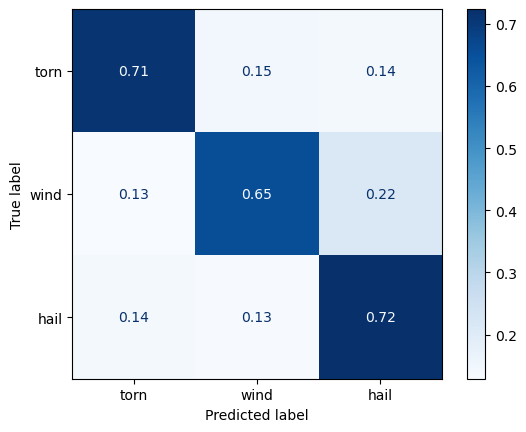

In [9]:
print('============================= Original XGBoost =============================')
xgb = XGBClassifier( )
xgb.fit( train_x, train_y ) 
evaluate( xgb, train_x, train_y, test_x, test_y )

print('============================= XGBoost with RFE =============================')
xgb = XGBClassifier( )
rfe_xgb = RFE(xgb, n_features_to_select=12)
rfe_xgb.fit( train_x, train_y )
evaluate( rfe_xgb, train_x, train_y, test_x, test_y )
features = train_x.columns.to_list()
for x, y in (sorted(zip(rfe_xgb.ranking_ , features), key=itemgetter(0))):
    print(x, y)

print('============================= XGBoost with RFA =============================')
xgb = XGBClassifier( )
rfa_xgb = RecursiveFeatureAddition(estimator=xgb, scoring="accuracy", cv=3)
vars = rfa_xgb.fit_transform(train_x, train_y) 
vars = vars.columns.tolist() 
print(vars)
print( rfa_lgb.initial_model_performance_ ) 
print( rfa_lgb.performance_drifts_ ) 

xgb = LGBMClassifier( )  
xgb.fit( train_x[vars], train_y )
evaluate(xgb, train_x[vars], train_y, test_x[vars], test_y) 